In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_time_series(n_series, n_steps):
    # generates series that are the sum of two sine functions (fixed amplitudes, random frequencies and phases)
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, n_series, 1)
    time = np.linspace(0,1,n_steps)
    series = 0.5*np.sin((time-offsets1)*(10*freq1+10))
    series += 0.2*np.sin((time-offsets2)*(20*freq2+20))
    series += 0.1*(np.random.randn(n_series,n_steps)-0.5)
    return series.reshape(n_series,n_steps,1)

**goal**: predict 10 time steps ahead

In [3]:
ahead = 10
n_steps = 50
n_series = 1000
series = generate_time_series(n_series=n_series, n_steps=n_steps+ahead)
series.shape

(1000, 60, 1)

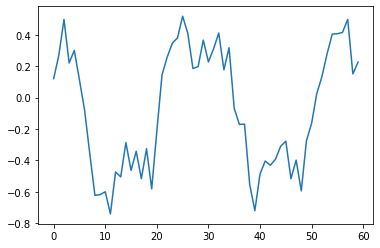

In [4]:
plt.plot(series[0])

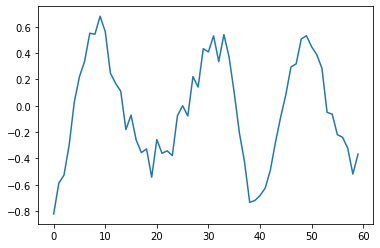

In [5]:
plt.plot(series[111])

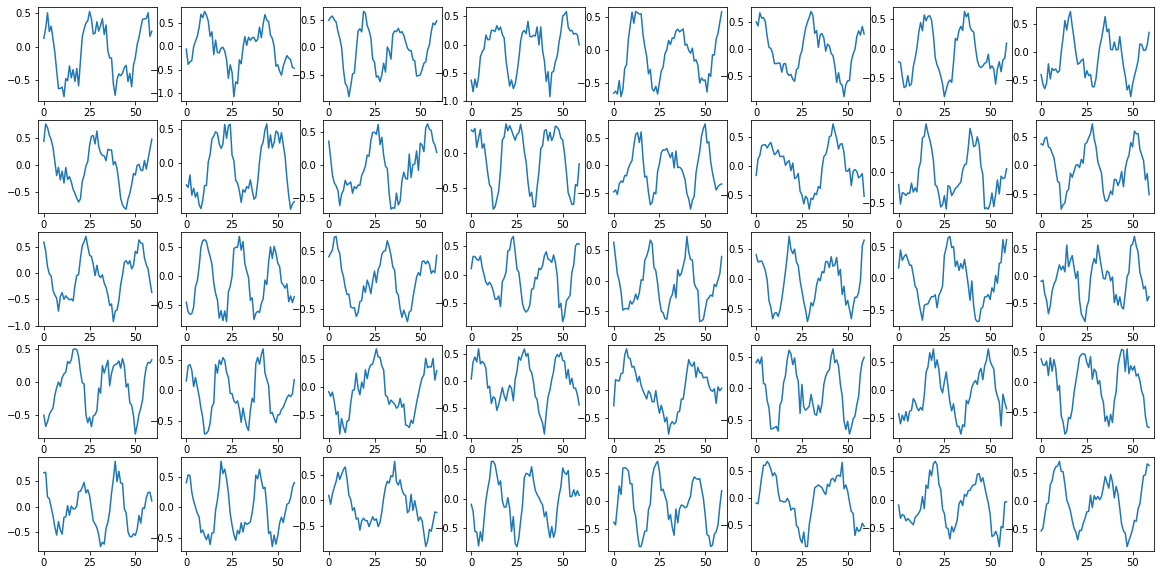

In [6]:
plt.figure(figsize=(20,10))
idx = 0
for i in range(5):
    for j in range(8):
        plt.subplot(5,8,idx+1)
        plt.plot(series[idx])
        idx+=1

## Recurrent layers

In [7]:
# recurrent layer
class recurrent_layer:
    
    
    def __init__(self,n_inputs, n_neurons): 
        
        # initialization (weights and biases)
        self.weights = 0.1*np.random.randn(n_inputs+n_neurons,n_neurons)
        self.biases = np.zeros((1,n_neurons))
        
        # save sizes
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        
    # forward pass: pass the data through the layer
    def forward(self, inputs1, inputs2):
        # save inputs
        self.inputs1 = inputs1
        self.inputs2 = inputs2
        self.inputs = np.c_[inputs1,inputs2]
        
        # output
        self.output = self.inputs.dot(self.weights) + self.biases
        
    def backward(self, dinputs):
        
        # gradient
        self.dinputs = dinputs.dot(self.weights.T)[:,0:self.n_inputs]
            
        # gradients on parameters
        self.dweights = self.inputs.T.dot(dinputs)
        self.dbiases = np.sum(dinputs, axis=0, keepdims=True)
        
class layer:
    
    # initialization (weights and biases)
    def __init__(self,n_inputs, n_neurons): # self represents the instance of the class
        self.weights = 0.1*np.random.randn(n_inputs,n_neurons) # small random numbers
        self.biases = np.zeros((1,n_neurons))# zeros
        
    # forward pass: pass the data through the layer
    def forward(self, inputs):
        # we need to store the output
        self.output = inputs.dot(self.weights) + self.biases
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dinputs):
        
        # gradient
        self.dinputs = dinputs.dot(self.weights.T)
        
        # gradients on parameters
        self.dweights = self.inputs.T.dot(dinputs)
        self.dbiases = np.sum(dinputs, axis=0, keepdims=True)
        
# activation function
class ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dinputs):

        # copy dvalues
        self.dinputs = dinputs.copy()
        
        # zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0
        
        
# linear activation function: outputs = inputs
class linear:

    def forward(self, inputs):
        # flatten the output
        self.inputs = inputs
        self.output = inputs.flatten()

    def backward(self, dinputs):
        # derivative of x is 1 
        self.dinputs = dinputs.copy().reshape(-1,1) # reshape the result as a column vector
        
# mean squeared error        
class loss_mse():

    def forward(self, y_pred, y_true):

    # calculate loss
        sample_losses = (y_true - y_pred)**2
        # return losses
        return sample_losses

    def backward(self, y_pred, y_true):

        # number of data points
        samples = len(y_pred)

        # gradient 
        self.dinputs = -2 * (y_true - y_pred) 

        # normalize gradient
        self.dinputs = self.dinputs / samples
        
class optimizer_GD:

    def __init__(self, learning_rate=1):
        self.learning_rate = learning_rate
        
    def update_parameters(self, layer):
        
        # apply gradient descent iteration
        layer.weights = layer.weights - self.learning_rate*layer.dweights
        layer.biases = layer.biases - self.learning_rate*layer.dbiases

In [8]:
layer1 = recurrent_layer(n_inputs=1, n_neurons=100)
activation1 = ReLU()

layer2 = recurrent_layer(n_inputs=100, n_neurons=50)
activation2 = ReLU()

layer3 = layer(n_inputs=50, n_neurons=1)
activation3 = linear()

loss = loss_mse()
optimizer = optimizer_GD(learning_rate=.5)

In [9]:
n_epochs = 40

for epoch in range(n_epochs):
    # time step 0 - forward pass
    t = 0
    X = series[:,t,:]

    layer1.forward(X,np.zeros((len(X),100)))
    activation1.forward(layer1.output)

    layer2.forward(activation1.output, np.zeros((len(X),50)))
    activation2.forward(layer2.output)

    layer3.forward(activation2.output)
    activation3.forward(layer3.output)

    losses = loss.forward(activation3.output, series[:,t+10,:].flatten())

    # time step 0 - backward pass
    loss.backward(activation3.output, series[:,t+10,:].flatten())

    activation3.backward(loss.dinputs)
    layer3.backward(activation3.dinputs)

    activation2.backward(layer3.dinputs)
    layer2.backward(activation2.dinputs)

    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs)

    # update parameters
    optimizer.update_parameters(layer1)
    optimizer.update_parameters(layer2)
    optimizer.update_parameters(layer3)


    for t in range(1,50):
        X = series[:,t,:]

        # forward
        layer1.forward(X,layer1.output)
        activation1.forward(layer1.output)

        layer2.forward(activation1.output, activation2.output)
        activation2.forward(layer2.output)

        layer3.forward(activation2.output)
        activation3.forward(layer3.output)

        losses = loss.forward(activation3.output, series[:,t+10,:].flatten())

        # backward pass
        loss.backward(activation3.output, series[:,t+10,:].flatten())

        activation3.backward(loss.dinputs)
        layer3.backward(activation3.dinputs)

        activation2.backward(layer3.dinputs)
        layer2.backward(activation2.dinputs)

        activation1.backward(layer2.dinputs)
        layer1.backward(activation1.dinputs)

        # update parameters
        optimizer.update_parameters(layer1)
        optimizer.update_parameters(layer2)
        optimizer.update_parameters(layer3)

    print(np.mean(losses))

0.06901018630061433
0.06932479048797976
0.06462065610774229
0.06199567170180307
0.06017651783534605
0.05953580476087645
0.05840583646172398
0.05755210696728651
0.05690326153210348
0.05622152941752139
0.05639821350141761
0.055313954747133534
0.05151759428524664
0.05075070472663327
0.05043487740439844
0.048989530916055006
0.048423288502855016
0.04628039310748509
0.04487566770282739
0.0444097857655922
0.0441598226802213
0.043544020212593786
0.0434035516887918
0.043207992367888394
0.04305038056441316
0.04268174892706908
0.04212342247201259
0.041980193823835756
0.041804362491395866
0.04165024569523449
0.041292585215887544
0.04141573806337321
0.04164265083164108
0.04227473576228171
0.04202909844089968
0.04309019238712931
0.042630727010429866
0.041415218014911055
0.04063440009253761
0.04061699500803338


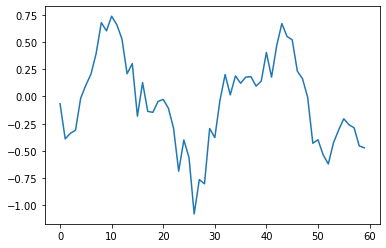

In [10]:
plt.plot(series[1])

In [11]:
# forward pass
t = 0
X = series[:,t,:]
y_pred = np.zeros((1000,50))

layer1.forward(X,np.zeros((len(X),100)))
activation1.forward(layer1.output)

layer2.forward(activation1.output, np.zeros((len(X),50)))
activation2.forward(layer2.output)

layer3.forward(activation2.output)
activation3.forward(layer3.output)

y_pred[:,t] = activation3.output

for t in range(1,50):
    X = series[:,t,:]

    # forward
    layer1.forward(X,layer1.output)
    activation1.forward(layer1.output)

    layer2.forward(activation1.output, activation2.output)
    activation2.forward(layer2.output)

    layer3.forward(activation2.output)
    activation3.forward(layer3.output)
    
    y_pred[:,t] = activation3.output

In [12]:
activation3.output.shape

(1000,)

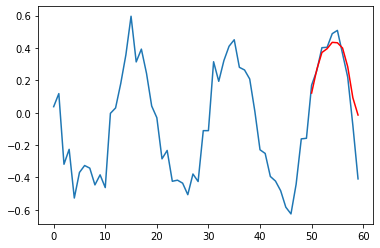

In [13]:
idx = 666
plt.plot(series[idx])
plt.plot(np.arange(50,60),y_pred[idx,-10:],color='red')